In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import urllib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from sklearn.kernel_ridge import KernelRidge

import helpers  # Notebook helper functions

sys.path.append(os.path.join('..'))
from counterfactual.curve import * 
from counterfactual.utility import *
from counterfactual.plot import *
from counterfactual.funcs import *
from counterfactual.optim import *

/Users/dinouye/anaconda3/envs/adp-env-3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Fetch/download data
D = helpers.fetch_german_data()
X, y, dtypes, feature_labels = D['X'], D['y'], D['dtypes'], D['feature_labels']

# Numeric only
numeric = ~is_categorical(dtypes)
X = X[:, numeric]
feature_labels = feature_labels[numeric]
dtypes = dtypes[numeric]

# Get train test splits
X, y = shuffle(X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print('# train', len(y_train))
print('# test', len(y_test))

# train 900
# test 100


In [3]:
# Train models
model_names = ['RBFSVM', 'RandomForest', 'DNN', 
               'DecisionTree', 'GradientBoost']
model_dicts = helpers.create_and_train_models(model_names, dtypes, X_train, y_train, X_test=X_test, y_test=y_test)

Loading fitted model from cache via file cached_model_764af53904d37432a92df8a7390bc8dc054e4b75.pkl
Loading fitted model from cache via file cached_model_d5d4430e323b00ba39bc64e7d3b56056a6040b8e.pkl
Loading fitted model from cache via file cached_model_ee48924d58e411b8367991894f08fd001faa2c5d.pkl
Loading fitted model from cache via file cached_model_9557f1a68edba8dcc02d7792f49030fb6dec7dcf.pkl
Loading fitted model from cache via file cached_model_daaa9d006a7ac9ac191d52e2146c5ca18ebae2b2.pkl


Automatic pdb calling has been turned ON


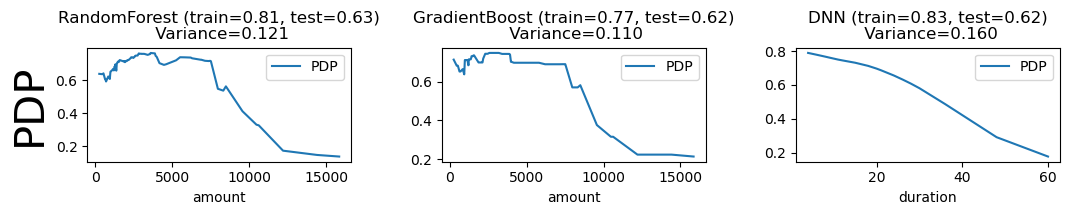

In [4]:
%pdb on
sys.path.append(os.path.join('monkey_patch'))
from sklearn_partial_dependence import my_get_partial_dependence

rng = check_random_state(0)
rand_idx = rng.permutation(X.shape[0])
n_X_samples = 100
n_grid = 50
X_sample = X[rand_idx[:n_X_samples]]

features = [0, 1, 2, 3, 4, 5, 6]


#model_names = ['RBFSVM', 'RandomForest', 'DNN', 'DecisionTree', 'GradientBoost']
sidx = np.argsort([-d['test_score'] for d in model_dicts])
sidx = [1, 4, 2]#np.argsort([-d['test_score'] for d in model_dicts])
utilities = [
    lambda model, x0: LeastMonotonicUtility(model),
    #lambda model, x0: LeastKernelRidgeUtility(model), 
    #lambda model, x0: ModelComparisonUtility(
    #    model=model, other_model=helpers.create_constant_model(model=model, x0=x0)
    #),
]
n_rows, n_cols = len(utilities), len(sidx)
fig, axes_mat = plt.subplots(n_rows, n_cols, figsize=np.array([n_cols*4, n_rows*2.5])*0.9, dpi=100)
axes_mat = axes_mat.reshape(n_rows, n_cols)  # In case n_rows=1 or n_cols=1
for ii, (U, axes) in enumerate(zip(utilities, axes_mat)):
    for jj, (d, ax) in enumerate(zip(model_dicts[sidx], axes)):
        model = d['model']
        model_scores = model(X)
        y_bounds = [np.min(model_scores), np.max(model_scores)]
        
        estimator = d['estimator']
        estimator = estimator.best_estimator_
        
        final_pdresults = 0
        final_feature_name = ''
        max_var = 0
        var = 0
        for i, name in enumerate(feature_labels):
            pd_results, feature_vals = my_get_partial_dependence(estimator, X_sample, [i], ax=ax) 
            var = np.std(pd_results[0][0][0])
            #print (var, i, name)
            if var >= max_var:
                max_var = np.std(pd_results[0][0][0])
                final_pdresults = pd_results
                final_feature_name = name

        ax.plot(final_pdresults[0][1][0], final_pdresults[0][0][0], label='PDP')
        ax.set_xlabel(final_feature_name)
        ax.legend()
        if jj == 0:
            ax.set_ylabel('PDP', fontsize=30)
        if ii == 0:
            ax.set_title('%s (train=%.2f, test=%.2f)\n Variance=%.3f' 
                         % (d['model_name'], d['train_score'], d['test_score'], max_var))
fig.tight_layout()
plt.savefig('comparison-pdp.pdf', bbox_inches='tight', pad_inches=0.1)

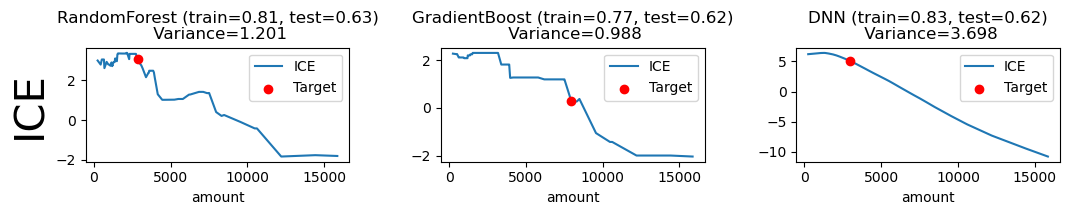

In [5]:
from ice import ice, ice_plot

rng = check_random_state(0)
rand_idx = rng.permutation(X.shape[0])
n_X_samples = 100
n_grid = 50
X_sample = X[rand_idx[:n_X_samples]]

features = [0, 1, 2, 3, 4, 5, 6]


#model_names = ['RBFSVM', 'RandomForest', 'DNN', 'DecisionTree', 'GradientBoost']
sidx = np.argsort([-d['test_score'] for d in model_dicts])
sidx = [1, 4, 2]#np.argsort([-d['test_score'] for d in model_dicts])
utilities = [
    lambda model, x0: LeastMonotonicUtility(model),
    #lambda model, x0: LeastKernelRidgeUtility(model), 
    #lambda model, x0: ModelComparisonUtility(
    #    model=model, other_model=helpers.create_constant_model(model=model, x0=x0)
    #),
]
n_rows, n_cols = len(utilities), len(sidx)
fig, axes_mat = plt.subplots(n_rows, n_cols, figsize=np.array([n_cols*4, n_rows*2.5])*0.9, dpi=100)
axes_mat = axes_mat.reshape(n_rows, n_cols)  # In case n_rows=1 or n_cols=1
for ii, (U, axes) in enumerate(zip(utilities, axes_mat)):
    for jj, (d, ax) in enumerate(zip(model_dicts[sidx], axes)):
        model = d['model']
        model_scores = model(X)
        y_bounds = [np.min(model_scores), np.max(model_scores)]
        
        estimator = d['estimator']
        
        final_feature_name = ''
        max_var = 0
        final_sample_idx = -1
        final_feature_idx = -1
        
        #for data in X_sample:
        #    X_df = pd.DataFrame(data.reshape(1,-1), columns=feature_labels)
        X_df = pd.DataFrame(X_sample, columns=feature_labels)
        for i, name in enumerate(feature_labels):
            ice_df = ice(X_df, name, model, num_grid_points=100)
            ice_numpy = ice_df.to_numpy()
            stds = np.std(ice_numpy, axis = 0)
            if np.max(stds) >= max_var:
                max_var = np.max(stds)
                final_feature_name = name
                final_feature_idx = i
                final_sample_idx = np.argmax(stds)
        
        ice_df = ice(X_df, final_feature_name, model, num_grid_points=100)
        feature_vals = ice_df.axes[0].tolist()
        y_vals = ice_df.iloc[:, final_sample_idx].to_numpy()
        idx = np.argwhere(np.diff(np.sign(feature_vals - X_sample[final_sample_idx, final_feature_idx]))).flatten()
        ax.scatter(feature_vals[idx[0]], y_vals[idx[0]], color='r', label='Target', zorder=2)
        ax.plot(feature_vals, y_vals, label='ICE', zorder=1)
        
        ax.set_xlabel(final_feature_name)
        ax.legend()
        if jj == 0:
            ax.set_ylabel('ICE', fontsize=30)
        if ii == 0:
            ax.set_title('%s (train=%.2f, test=%.2f)\n Variance=%.3f' 
                         % (d['model_name'], d['train_score'], d['test_score'], max_var))
fig.tight_layout()
plt.savefig('comparison-ice.pdf', bbox_inches='tight', pad_inches=0.1)
#plt.savefig('comparison-ice-gray.pdf', bbox_inches='tight', pad_inches=0)
#plt.savefig('comparison-ice-gray.pdf', bbox_inches='tight', pad_inches=0.1, facecolor=[0.9, 0.9, 0.9])

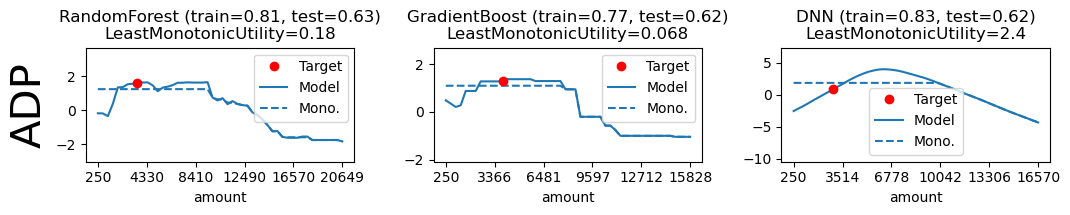

In [10]:
rng = check_random_state(0)
rand_idx = rng.permutation(X.shape[0])
n_X_samples = 100
n_grid = 50
X_sample = X[rand_idx[:n_X_samples]]

#model_names = ['RBFSVM', 'RandomForest', 'DNN', 'DecisionTree', 'GradientBoost']
sidx = np.argsort([-d['test_score'] for d in model_dicts])
sidx = [1, 4, 2]#np.argsort([-d['test_score'] for d in model_dicts])
utilities = [
    lambda model, x0: LeastMonotonicUtility(model),
    #lambda model, x0: LeastKernelRidgeUtility(model), 
    #lambda model, x0: ModelComparisonUtility(
    #    model=model, other_model=helpers.create_constant_model(model=model, x0=x0)
    #),
]
n_rows, n_cols = len(utilities), len(sidx)
fig, axes_mat = plt.subplots(n_rows, n_cols, figsize=np.array([n_cols*4, n_rows*2.5])*0.9, dpi=100)
axes_mat = axes_mat.reshape(n_rows, n_cols)  # In case n_rows=1 or n_cols=1
for ii, (U, axes) in enumerate(zip(utilities, axes_mat)):
    for jj, (d, ax) in enumerate(zip(model_dicts[sidx], axes)):
        model = d['model']
        model_scores = model(X)
        y_bounds = [np.min(model_scores), np.max(model_scores)]
        
        # Fit for every sample
        utilities_per_x0 = np.array([U(model=model, x0=xx) for xx in X_sample])
        best_curves = np.array([
            optimize_curve(x0=xx, utility=uu, X=X, dtypes=dtypes, max_numeric_change=1)
            for xx, uu in zip(X_sample, utilities_per_x0)
        ])
        best_utilities = np.array([uu(best_curve, n_grid=n_grid) 
                                   for best_curve, uu in zip(best_curves, utilities_per_x0)])
        
        # Choose best sample
        best_idx = np.argmax(best_utilities)
        best_curve = best_curves[best_idx]
        best_utility = utilities_per_x0[best_idx]
        
        # Plot
        plot_curve_vals(curve=best_curve, utility=best_utility, feature_labels=feature_labels, y_bounds=y_bounds,
                        auxiliary_scoring=None, tick_rotation=15, ax=ax, 
                        model_label='Model', other_model_label='Mono.',
                        legend_kwargs=dict(loc='best'))
        if jj == 0:
            ax.set_ylabel('ADP', fontsize=30)
        if ii == 0:
            ax.set_title('%s (train=%.2f, test=%.2f)\n%s' 
                         % (d['model_name'], d['train_score'], d['test_score'], ax.get_title()))
fig.tight_layout()
#fig.patch.set_facecolor([0.9, 0.9, 0.9])
plt.savefig('comparison-adp.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('comparison-adp-gray.pdf', bbox_inches='tight', pad_inches=0.1, facecolor=[0.9, 0.9, 0.9])